In [16]:
import torch
from torch import nn
from torch import optim
from torch import autograd as grad
import torchvision
from torchvision.transforms import ToTensor
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tensorflow as tf

In [17]:
FILE_PATH = "model.pth"

class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()  # Proper class inheritance
        self.L1 = nn.Linear(28 * 28, 28**2)  # Adjust input size to 28x28
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        nn.init.xavier_normal_(self.L1.weight)
        self.L2 = nn.Linear(28**2, 28*5)  # Output layer for 10 classes
        nn.init.xavier_normal_(self.L2.weight)
        self.L3 = nn.Linear(28*5, 10)
        self.softmax = nn.Softmax()

        self.dropout = nn.Dropout()

    def forward(self, x):
        x=self.L1(x)
        x=self.sigmoid(x)
        x=self.L2(x)
        x=self.dropout(x)
        x=self.relu(x)
        x=self.L3(x)
        x=self.softmax(x)
        return x

In [18]:
plot_list = []
def train_1_Epoch(net, train_ds, device):
    start_time = time.time()
    iter=0
    
    for inputX, targetY in train_ds:#range(len(train_ds)):
        # Fitting the input and the target to the model and to the device
        inputX = torch.flatten(inputX)

        targetY = torch.nn.functional.one_hot(targetY, num_classes=10)
        targetY = torch.tensor(targetY,dtype=float).flatten()

        # Transfer the input and the target to the GPU
        inputX = inputX.to(device)
        targetY = targetY.to(device)
        
        #initiating the optimization method and the loss function
        optimizer = optim.SGD(params=net.parameters() ,lr=1e-2, weight_decay=5e-4)# Utilizing momentum for gradient descent
        loss_func = nn.CrossEntropyLoss()

        pred = net.forward(inputX)
        # ---BackPropagation---
        loss = loss_func(pred,targetY)
        loss.backward()
        optimizer.step()
        
        if iter%100==0:
            plot_list.append(
                #(net.L1.weight.grad.sum().cpu() / len(net.L1.weight.grad.cpu())) # add the average gradient squared to a plotting list
                loss.item()#.cpu().detach().numpy()
            )
            print(f"prediction = {list(pred).index(max(pred))} : {targetY}")
            
            print(f"example number {iter}, runtime = {time.time()-start_time}")
            print(loss)

        optimizer.zero_grad()
        iter+=1

    # Save the network at the end
    torch.save(net.cpu(), FILE_PATH)

C:\Users\orian\AppData\Local\Temp\ipykernel_21076\4077596259.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targetY = torch.tensor(targetY,dtype=float).flatten()


prediction = 1 : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       dtype=torch.float64)
example number 0, runtime = 0.06700015068054199
tensor(2.3348, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
prediction = 7 : tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0',
       dtype=torch.float64)
example number 100, runtime = 0.7829971313476562
tensor(2.2903, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
prediction = 8 : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0',
       dtype=torch.float64)
example number 200, runtime = 1.30399751663208
tensor(2.3004, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
prediction = 7 : tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       dtype=torch.float64)
example number 300, runtime = 1.8402318954467773
tensor(2.3473, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
prediction = 7 : tensor([0., 0., 0., 0., 0., 0., 0., 0.

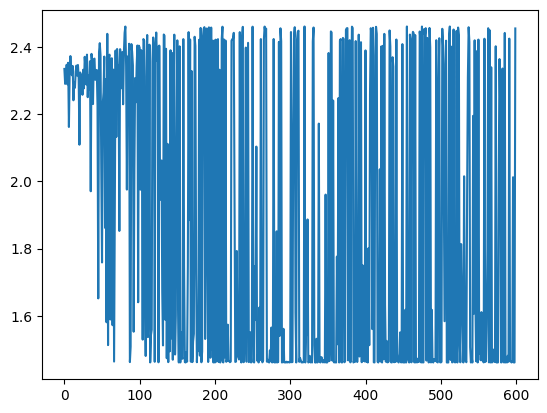

In [19]:
if __name__ == '__main__':
    train_data = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=ToTensor()
    )
    train_data = DataLoader(dataset=train_data, shuffle=True)

    # Set device for training
    if torch.cuda.is_available() : dev = "cuda:0"
    else : dev = "cpu"
    dev = torch.device(dev)
    net=BasicNet().to(dev)
    
    # Train loop per number of epochs
    train_1_Epoch(net, train_data, device=dev)
    
    # Plot the loss/gradient
    plt.plot(plot_list,'-')
    plt.show()

    ---Net Testing Cell---

In [20]:
def max_index(max_lst):
    max_num = 0
    for num in max_lst:
        if max_num < num:
            max_num = num
    return max_lst.index(max_num)


FILE = "model.pth"
model = torch.load(FILE)
model.eval()

# Beginning of the test
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
right_sum = 0


for iter in range(len(x_test)):
    testX = torch.tensor(x_train[iter],dtype=torch.float32)
    testX = torch.flatten(testX)
    targetY = torch.tensor(y_train[iter])
    
    pred_full = model.forward(testX)
    pred = max_index(list(pred_full))
    if pred == targetY:
        right_sum+=1
    
    if iter%1000 == 0:
        print(f" prediction:{pred} target:{targetY.numpy()}")
print(f"Model accuracy:{right_sum/len(x_test)*100}%")

"""for param in model.parameters():
    print(param)"""
    

 prediction:3 target:5
 prediction:0 target:0
 prediction:8 target:5
 prediction:0 target:9
 prediction:7 target:7
 prediction:7 target:7
 prediction:6 target:6
 prediction:8 target:8
 prediction:0 target:0
 prediction:6 target:6
Model accuracy:71.76%


'for param in model.parameters():\n    print(param)'